# <center>Zn and Cr column density limits for the Pitt dR4+dR7 Catalog </center>

* ### Started from $\sim 29 000$ spectra from SDSS dR4 (Pitt Catalog) + dR7 (Eric's list).
* ### We can find ZnII in MgII absorbers from $z_{abs} = [0.88, 3.54]$.
* ### Magnitudes cuts were implemented $g \leq $ 19.0 and $r \leq 18.7$.
* ### $W_0^{\lambda2796} \geq 0.5 \AA$.
* ### All cuts considered gives 2400-ish spectra to calculate EW limits from

In [1]:
# Python modules that are useful here.
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
%matplotlib inline

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

## <center>I. Re-writing the IDL code that calculates the rest-equivalent width limits </center>
#### Code below calculates EW limits using the normalized error array. 

In [2]:
def EW_limits(wave, nflux, nerr):
    p=2.35 #for sloan pixels per res el
    PP=np.ceil(2*p+1) #one whole feature has this many pixels
    
    tot_ew=np.zeros(len(wave))
    tot_sig_ew=np.zeros(len(wave))
    
    del_lambda = 0.5*(wave - wave.shift(1))
    ew = del_lambda*(1-nflux)
    sig_ew = del_lambda*nerr
    sse=np.array(sig_ew)**2

    for k in range(int(PP/2-1), int(len(wave) - PP/2 -1 + 1)):
        tot_sig_ew[k] = np.sqrt(np.sum(sse[k-2:k+2+1])) #Error array for EW per resel
    
    return tot_sig_ew

## <center>II. Load in the list of spectra and calulate EW width limits </center>
####  Final output is calculated in the absorber rest-frame at the $2\sigma$ UPPER LIMIT-level.

In [3]:
spec_list = pd.read_csv('~/Documents/Research/EricDLAMgII/SearchForZincinMgII.txt')
metals = [2026.136, 2056.2539, 2062.234, 2066.161, 2852.9642]
keys = ['Zn_lim_2026_ALL','Cr_lim_2056','Zn_lim_2062_ALL', 'Cr_lim_2066', 'MgII_lim']
data = {key: [] for key in keys}

for i in range(len(spec_list)):
    file_i = "/Volumes/Hubble/spSpec-"+str(spec_list.mjd[i])+'-'+str(spec_list.plate[i]).rjust(4,'0')+ \
               '-'+str(spec_list.fiberid[i]).rjust(3, '0')+'.n'
    spec = pd.read_csv(file_i, delim_whitespace=True, skiprows=1)
    spec.columns = ['wave', 'flux', 'nflux', 'nerr', 'id', 'pseudo_cont']
    ew_limits = 2.0*EW_limits(spec.wave, spec.nflux, spec.nerr)/(1.+spec_list.up_Dzabs[i])
    for j in range(len(keys)):
        data[keys[j]].append(ew_limits[np.argmin(np.abs(spec.wave/(1.+spec_list.up_Dzabs[i]) - metals[j]))])    


## <center>III. Infer limits of strongly blended lines using inspiration from Dan's and Gen's paper! </center>

In [4]:
#Estimate ZnII2026 using MgI2852 limits
data['Zn_lim_2026'] = np.array(data['Zn_lim_2026_ALL']) - np.array(data['MgII_lim'])/32.
#Estimate CrII2062 from 0.5*(CrII2056+CrII2066)
Cr_limits_2062 = np.array(data['Zn_lim_2062_ALL']) - 0.5*(np.array(data['Cr_lim_2056'])
                                                             +np.array(data['Cr_lim_2066']))
Cr_limits_2062[np.where(Cr_limits_2062 < 0)] = 0.
data['Cr_lim_2062'] = Cr_limits_2062
#Zn2062
data['Zn_lim_2062'] = data['Zn_lim_2062_ALL'] - data['Cr_lim_2062']

## <center>IV. Convert EWs into column densities of the metal assuming dominant transition truly dominates, assuming sufficient self-shielding, and the *<font color='green'>**linear regime**</font>*. </center>
####  Final REW is reported using the strongest transition in a group of transitions.

In [5]:
#Calculate column densities
#The column density should be the maximum limit.
Osc_strengths = [ 0.48900,     0.140]#,   0.105,     0.253,   0.0515,    1.8100]
rest_wave     = [2026.136, 2056.2539]#, 2062.234, 2062.664, 2066.161, 2852.9642]
##Zn Column density limits
Zn_col_density = 1.13e20*data['Zn_lim_2026']/rest_wave[0]**2/Osc_strengths[0]
Cr_col_density = 1.13e20*np.array(data['Cr_lim_2056'])/rest_wave[1]**2/Osc_strengths[1]

## <center>V. Comments </center>

Typical values of Zn column densities in the sample (see Excel file sent to Eric) are $N_{Zn}\sim 10^{13} atoms/cm^{2}$. We now ask how many of the limits are in this range?

In [6]:
print '\t \t There are {} spectra that have 2-sigma REW limits for Zn ~ 10^13 atoms/cm^2,'\
.format(len(Zn_col_density[Zn_col_density < 1e13]))
print '\t \t The minimum value of which is {0:.2f}e11 atoms per cm^2.'.format(min(Zn_col_density[Zn_col_density < 1e13]/1e11))
print '\t \t There are {} total MgII absorbers investigated for ZnII.'.format(len(Zn_col_density))

	 	 There are 2396 spectra that have 2-sigma REW limits for Zn ~ 10^13 atoms/cm^2,
	 	 The minimum value of which is 6.17e11 atoms per cm^2.
	 	 There are 2417 total MgII absorbers investigated for ZnII.


### <center>The 2396 REW-limits are distributed as below. </center> </font> 

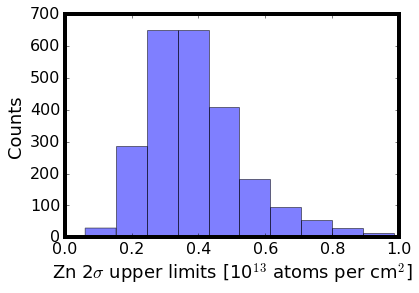

In [7]:
plt.hist(Zn_col_density[Zn_col_density < 1e13]/1e13, alpha=0.5)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Zn '+r'2$\sigma$ upper limits [10$^{13}$ atoms per cm$^2$]', fontsize=18)

### <center>VI. From the MgII catalog we have 103-ish ZnII measured. And we plot the REW distributions below. </center>

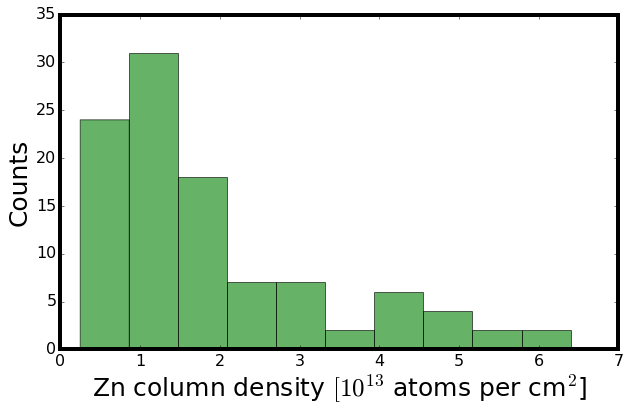

In [8]:
#Measured CrII and ZnII
catalog_Zn = pd.read_csv('~/Documents/Research/EricDLAMgII/ZnII_in_MgII_dR4_dR7_103.txt')
#Convert to REWs:
REW_ZnII_2026 = (catalog_Zn.EW2026_all - catalog_Zn.EW2852/32.)/(1.+catalog_Zn.zabs)
eREW_ZnII_2026 = np.sqrt(catalog_Zn.EW2026_all_err**2 + (catalog_Zn.EW2852_err/32.)**2)/(1.+catalog_Zn.zabs)
#Convert to Zn column density:
catalog_Zn_col_density = 1.13e20*REW_ZnII_2026/rest_wave[0]**2/Osc_strengths[0]
plt.hist(catalog_Zn_col_density/1e13, bins=10, color='green', alpha=0.6)
plt.ylabel('Counts', fontsize=25)
plt.xlabel(r'Zn column density $[10^{13}$ atoms per cm$^2$]', fontsize=25)

### <center>Consider only those with $W_0^{\lambda2026} \geq 5\sigma $    </center> </font> 

	 	 There are 88 good measurements of ZnII 2026 at better than 2-sigma level.


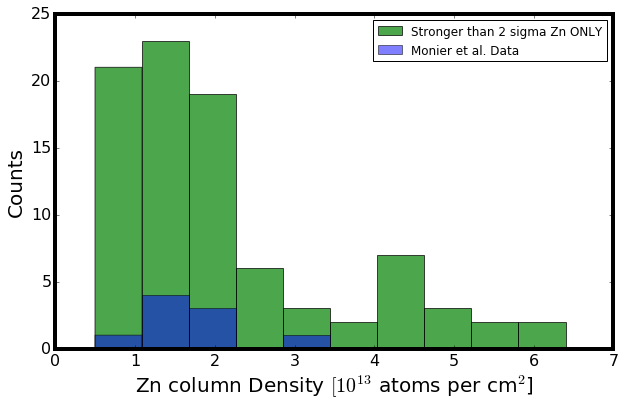

In [22]:
good_Zn_REW = REW_ZnII_2026[REW_ZnII_2026/eREW_ZnII_2026 >= 2]
ZnData = [1.2e13, 1.3e13,1.3e13, 2.2e13, 2.1e13, 2.0e13,2.9e13,1.6e13,9.4e12]
print "\t \t There are {} good measurements of ZnII 2026 at better than 2-sigma level.".format(len(good_Zn_REW))
#Convert to Zn column density:
catalog_Zn_col_density = 1.13e20*good_Zn_REW/rest_wave[0]**2/Osc_strengths[0]
n, bins, patches = plt.hist(catalog_Zn_col_density/1e13, bins=10, color='green', alpha=.7, 
                            label='Stronger than 2 sigma Zn ONLY')
plt.hist(np.array(ZnData)/1e13, alpha=0.5, bins=bins, label='Monier et al. Data')
plt.ylabel('Counts', fontsize=20)
plt.xlabel(r'Zn column Density $[10^{13}$ atoms per cm$^2$]', fontsize=20)
plt.legend()

# Conclusion:
>> The blue histogram of the **UPPER** limits above tell me that the typical Zn column densities are weaker. What these 103-ish Zn II systems we have represent the highest column densities in our sample of MgII's. But isn't this the reason why we can measure them in SDSS spectra in the first place? 